# Data Preparation for RAG Pipeline

## Environment Setup

In [1]:
# Imports

import os
import json
import chromadb
import warnings
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_experimental.text_splitter import SemanticChunker
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.document_loaders import PyPDFDirectoryLoader

from llama_parse import LlamaParse
from llama_index.core import Settings

np.float_ = np.float64
warnings.filterwarnings('ignore')

In [2]:
# Env variables

load_dotenv()

LLAMA_KEY = os.environ["LLAMA_KEY"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]

In [3]:
# Constants
DOCS_DIR = "../data/docs/"
STORE_DIR = "../data/store/"

CHAT_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-ada-002"

## LLM Configuration

In [4]:
# Initialize the OpenAI embedding function for Chroma
embedding_function = chromadb.utils.embedding_functions.OpenAIEmbeddingFunction(
    api_base=OPENAI_API_BASE,
    api_key=OPENAI_API_KEY,
    model_name=EMBEDDING_MODEL
)

In [5]:
# Initialize the OpenAI Embeddings
embedding_model = OpenAIEmbeddings(
    openai_api_base=OPENAI_API_BASE,
    openai_api_key=OPENAI_API_KEY,
    model=EMBEDDING_MODEL
)

In [6]:
# Initialize the Chat OpenAI model
llm = ChatOpenAI(
    openai_api_base=OPENAI_API_BASE,
    openai_api_key=OPENAI_API_KEY,
    model=CHAT_MODEL,
    streaming=False
)

In [7]:
# Set the LLM and embedding model in the LlamaIndex settings
Settings.llm = llm
Settings.embedding = embedding_model

## Data Parsing and Preparation for Efficient Information Retrieval

Here, we lay the groundwork for the AI Nutrition Disorder Specialist bot by meticulously parsing and preparing data from various nutritional disorder documents. We begin by importing the necessary libraries, followed by setting up configurations for OpenAI models. Next, we parse PDF content using LlamaParse to extract tables and validate parsed JSON objects. We then perform semantic chunking of text for structured retrieval, and generate hypothetical questions and metadata for these text chunks and tables. Finally, we store everything in ChromaDB, ensuring efficient retrieval and processing of relevant information for the bot's responses. This structured approach equips the AI with the ability to provide accurate and contextually relevant answers to user queries related to nutritional disorders.

### Parsing and Extracting Content from the Documents

Setting Up Async Environment for LlamaParse

In [8]:
# Import necessary library for async operations in notebooks
import nest_asyncio

# Apply the nested async loop to allow async code execution in the notebook
nest_asyncio.apply()

Initializing LlamaParse for PDF Parsing

In [9]:
# Initialize LlamaParse with desired settings
parser = LlamaParse(
    result_type="markdown",                     # Specify the result format
    skip_diagonal_text=True,                    # Skip diagonal text in the PDFs
    fast_mode=False,                            # Use normal mode for parsing
    num_workers=9,                              # Number of workers for parallel processing
    check_interval=10,                          # Check interval for processing
    api_key=LLAMA_KEY                           # API key for LlamaParse
)

Parsing Content from PDFs

In [10]:
# List to store parsed JSON objects
json_objs = []

# Iterate through PDFs in the folder and parse content
for pdf in os.listdir(DOCS_DIR):
    if pdf.endswith('.pdf'):
        pdf_path = os.path.join(DOCS_DIR, pdf)
        json_objs.extend(parser.get_json_result(pdf_path))

Started parsing the file under job_id b42ae36f-5129-4ff3-bed2-62676190d85d


In [11]:
# Pretty print JSON object for inspection
print(json.dumps(json_objs[0], indent=4))

{
    "pages": [
        {
            "page": 1,
            "text": "The Merck Manual of Diagnosis & Therapy, 19th Edition    Chapter 1. Nutrition: General Considerations\n\n1 - Nutritional Disorders\n\nChapter 1. Nutrition: General Considerations\n\nIntroduction\n\nNutrition is the science of food and its relationship to health. Nutrients are chemicals in foods that are\nused by the body for growth, maintenance, and energy. Nutrients that cannot be synthesized by the body\nand thus must be derived from the diet are considered essential. They include vitamins, minerals, some\namino acids, and some fatty acids. Nutrients that the body can synthesize from other compounds,\nalthough they may also be derived from the diet, are considered nonessential. Macronutrients are\nrequired by the body in relatively large amounts; micronutrients are needed in minute amounts.\n\nLack of nutrients can result in deficiency syndromes (eg, kwashiorkor, pellagra) or other disorders (see p.\n9). Excess in

Extracting Tables from Parsed JSON Objects

In [12]:
# Initialize dictionaries to store page texts and tables
page_texts, tables = {}, {}

# Extract tables from the parsed JSON objects
for obj in json_objs:
    json_list = obj['pages']
    name = obj["file_path"].split("/")[-1]                                  # Extract the file name
    page_texts[name] = {}                                                   # Initialize dictionary for page texts
    tables[name] = {}                                                       # Initialize dictionary for tables

    for json_item in json_list:
        for component in json_item['items']:
            if component['type'] == 'table':
                tables[name][json_item['page']] = component['rows']         # Store table rows

In [13]:
# Display extracted tables for each PDF
for file_name, file_tables in tables.items():
    print(f"Tables from {file_name}:")
    for page_num, table_rows in file_tables.items():
        print(f"  Page {page_num}:")
        for row in table_rows:
            print(row)

Tables from Nutritional Disorders.pdf:
  Page 1:
['Food', 'Glycemic Index']
['Glucose', '100']
['Sucrose', '65']
['Starches', 'Variable']
['Fiber', '0']
  Page 3:
  Page 17:
['Men:', 'kcal / day = 66 + (13.7 × wt[kg]) + (5 × height[cm]) - (6.8 × age)']
['Women:', 'kcal / day = 665 + (9.6 × wt[kg]) + (1.8 × height[cm]) - (4.7 × age)']
  Page 24:
['Vitamin', 'Recommended Daily Intake']
['Biotin', '30 μg']
['Pantothenic Acid', '5 mg']
['Folate', 'Varies']
  Page 35:
['Inadequate absorption', 'Decreased acid secretion (elderly)', 'Blind loop syndrome', 'Fish tapeworm infestation']
['Inflammatory bowel disease', 'Surgical removal of ileal absorptive sites', 'Chronic pancreatitis', 'Gastric surgery']
['Malabsorption syndromes', 'AIDS', 'Use of certain drugs (e.g., antacids, metformin)', 'Repeated exposure to nitrous oxide']
['Genetic disorder (Imerslund-Graesbeck syndrome)', '', '', '']


### Semantic Chunking and Structured Retrieval

#### PDF Parsing and Text Chunking Using SemanticChunker

In [14]:
# Initialize ChromaDB client
chromadb_client = chromadb.EphemeralClient()

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


Initialize the SemanticChunker with percentile breakpoint type and adjusted threshold

In [15]:
# Initialize the semantic text splitter, controlling how text is divided into meaningful chunks
semantic_text_splitter = SemanticChunker(
    embedding_model,
    breakpoint_threshold_type='percentile',
    breakpoint_threshold_amount=80
)

Text Chunking Using SemanticChunker

In [16]:
# Initialize an empty list to store all semantic chunks
semantic_chunks = []

# Initialize the PyPDFDirectoryLoader for the folder
pdf_loader = PyPDFDirectoryLoader(DOCS_DIR)

# Load and split PDF documents into chunks using SemanticChunker
chunks = pdf_loader.load_and_split(semantic_text_splitter)

# Extend the semantic_chunks list with the chunks from this folder
semantic_chunks.extend(chunks)

len(semantic_chunks)

402

#### Creating and Storing Document Chunks in Chroma Vectorstore

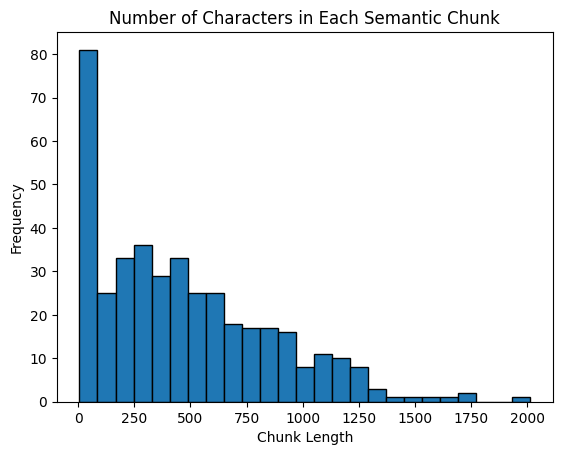

In [17]:
# Add IDs to the semantic chunks
semantic_chunks = [Document(id=i, page_content=d.page_content, metadata=d.metadata) for i, d in enumerate(semantic_chunks)]

# Plot a histogram of the number of characters in each semantic chunk
chunk_lengths = [len(chunk.page_content) for chunk in semantic_chunks]
plt.hist(chunk_lengths, bins=25, edgecolor='black')
plt.xlabel('Chunk Length')
plt.ylabel('Frequency')
plt.title('Number of Characters in Each Semantic Chunk')
plt.show()

Store the document chunks in Chroma vectorstore in batches

In [19]:
batch_size = 100
for i in range(0, len(semantic_chunks), batch_size):
    batch = semantic_chunks[i : i + batch_size]
    semanticstore = Chroma.from_documents(
        batch,
        embedding_model,
        collection_name="semantic_chunks",
        persist_directory=f"{STORE_DIR}research_db"
    )

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telem

Perform similarity search in the vectorstore

In [20]:
# Example user query
user_input = "What are the symptoms for vitamin B12 deficiency?"

# Perform similarity search in the vectorstore
docs = semanticstore.similarity_search(user_input, k=5)

# Display retrieved documents
for i in docs:
    print("Source:", i.metadata['source'])
    print("Page:", i.metadata['page'], "\n")
    print(i.page_content)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Source: ..\data\docs\Nutritional Disorders.pdf
Page: 33 

Vitamin B
12
 Deficiency
Dietary vitamin B
12
 deficiency usually results from inadequate absorption, but deficiency can
develop in vegans who do not take vitamin supplements. Deficiency causes megaloblastic
anemia, damage to the white matter of the spinal cord and brain, and peripheral neuropathy. Diagnosis is usually made by measuring serum vitamin B
12
 levels.
Source: ..\data\docs\Nutritional Disorders.pdf
Page: 34 

Some patients are also irritable and mildly depressed. Paranoia (megaloblastic madness), delirium,
confusion, spastic ataxia, and, at times, postural hypotension may occur in advanced cases. The
confusion may be difficult to differentiate from age-related dementias, such as Alzheimer's disease. Diagnosis
• CBC and vitamin B
12
 and folate levels
• Sometimes methylmalonic acid levels or Schilling test
The Merck Manual of Diagnosis & Therapy, 19th Edition Chapter 4. Vitamin Deficiency, Dependency & Toxicity
87
Sou

#### Structured Retrieval Using Self-Query Retriever

In [21]:
# Define metadata fields for structured retrieval
metadata_field_info = [
    AttributeInfo(
        name="Category",
        description="Category of the nutritional disorder (e.g., Undernutrition, Vitamin Deficiency, Obesity, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="DisorderType",
        description="Specific type of nutritional disorder (e.g., Protein-Energy Malnutrition, Scurvy, Rickets, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="Page",
        description="Page within the nutritional medical reference document that the information belongs to",
        type="integer"
    )
]

# Describe the content of the document
document_content_description = "Information about various nutritional disorders."

Initialize the self-querying retriever for semantic chunks and perform structutred retrieval

In [22]:
structured_retriever = SelfQueryRetriever.from_llm(
    llm,
    semanticstore,
    document_content_description,
    metadata_field_info
)

In [24]:
# Example user query
user_input = "What are the symptoms for vitamin B12 deficiency?"

# Perform structured retrieval using self-querying retriever
structured_retriever.invoke(user_input)

[Document(metadata={'page': 33, 'source': '..\\data\\docs\\Nutritional Disorders.pdf'}, page_content='Vitamin B\n12\n Deficiency\nDietary vitamin B\n12\n deficiency usually results from inadequate absorption, but deficiency can\ndevelop in vegans who do not take vitamin supplements. Deficiency causes megaloblastic\nanemia, damage to the white matter of the spinal cord and brain, and peripheral neuropathy. Diagnosis is usually made by measuring serum vitamin B\n12\n levels.'),
 Document(metadata={'page': 34, 'source': '..\\data\\docs\\Nutritional Disorders.pdf'}, page_content="Some patients are also irritable and mildly depressed. Paranoia (megaloblastic madness), delirium,\nconfusion, spastic ataxia, and, at times, postural hypotension may occur in advanced cases. The\nconfusion may be difficult to differentiate from age-related dementias, such as Alzheimer's disease. Diagnosis\n• CBC and vitamin B\n12\n and folate levels\n• Sometimes methylmalonic acid levels or Schilling test\nThe Me

### Creating Hypothetical Questions and Storing in Chroma Vectorstore

#### Generating Hypothetical Questions for Text Semantic Chunks

In [32]:
hypothetical_questions_prompt = """
Generate a list of exactly 5 hypothetical questions that the below nutritional disorder document could be used to answer:
{doc}

If the content cannot answer any questions, return an empty list.
Generate only a list of questions. Do not mention anything before or after the list.
Ensure that the questions are specific to nutritional disorders, dietary deficiencies, metabolic disorders, vitamin and mineral imbalances, obesity, and related health conditions.
"""

Generate hypothetical questions for each semantic chunk and store them in a structured format

In [33]:
# List to store documents with hypothetical questions
hypothetical_question_docs = []

# Generate hypothetical questions for each semantic chunk
for i, document in enumerate(semantic_chunks):
    try:
        # Invoke the LLM to generate questions based on the chunk content
        response = llm.invoke(hypothetical_questions_prompt.format(doc=document))
        questions = response.content
    except Exception as e:
        print(e)
        questions = "NA"

    # Create metadata for the generated questions
    questions_metadata = {
        'original_content': document.page_content,
        'source': document.metadata['source'],
        'page': document.metadata['page'],
        'type': 'text'
    }

    # Create and store the document containing generated questions
    hypothetical_question_docs.append(
        Document(
            id=str(i),
            page_content=questions,
            metadata=questions_metadata
        )
    )

<html>
<head><title>403 Forbidden</title></head>
<body>
<center><h1>403 Forbidden</h1></center>
</body>
</html>
Error code: 401 - {'error': {'message': 'Incorrect API key provided: org-WXoe****************Tj1Y. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Error code: 401 - {'error': {'message': 'Incorrect API key provided: org-WXoe****************Tj1Y. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Error code: 401 - {'error': {'message': 'Incorrect API key provided: org-WXoe****************Tj1Y. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Error code: 401 - {'error': {'message': 'Incorrect API key provided: org-mgDJ****************tCbq. You can find your API key at http

In [39]:
# Function to print a sample document with hypothetical questions
def print_sample(docs, index=0):
    print("ID:\n", docs[index].id, "\n")
    print("Metadata:")
    print(json.dumps(docs[index].metadata, indent=4), "\n")
    print("Hypothetical Questions:\n", docs[index].page_content)

# Print a sample document
print_sample(hypothetical_question_docs, 20)

ID:
 20 

Metadata:
{
    "original_content": "However, many nonnutrients in foods are\nuseful. For example, food additives (eg, preservatives, emulsifiers, antioxidants, stabilizers) improve the\nproduction and stability of foods. Trace components (eg, spices, flavors, odors, colors, phytochemicals,\nmany other natural products) improve appearance and taste. Fiber:\n Fiber occurs in various forms (eg, cellulose, hemicellulose, pectin, gums). It \nincreases GI motility,\nprevents constipation, and helps control diverticular disease. Fiber is thought to accelerate the elimination\nof cancer-causing substances produced by bacteria in the large intestine. Epidemiologic evidence\nsuggests an association between colon cancer and low fiber intake and a beneficial effect of fiber in\npatients with functional bowel disorders, Crohn's disease, obesity, and hemorrhoids. Soluble fiber\n(present in fruits, vegetables, oats, barley, and legumes) reduces the postprandial increase in blood\nglucose a

#### Generating Hypothetical Questions for Tables

In [40]:
hypothetical_questions_prompt = """
Generate a list of exactly 5 hypothetical questions that the below nutritional disorder table could be used to answer:
{table}

If the content cannot answer any questions, return an empty list.
Generate only a list of questions. Do not mention anything before or after the list.
Ensure that the questions are specific to nutritional disorders, dietary deficiencies, metabolic disorders, vitamin and mineral imbalances, obesity, and related health conditions.
"""

Generate hypothetical questions for tables in documents and store them as structured metadata

In [41]:
# List to store documents with hypothetical questions for tables
table_hypothetical_question_docs = []

# Generate hypothetical questions for each table in the documents
for source in tables:
    for page in tables[source]:
        table_in_page = tables[source][page]
        try:
            # Generate questions using the LLM
            response = llm.invoke(hypothetical_questions_prompt.format(table=table_in_page))
            questions = response.content
        except Exception as e:
            print(e)
            questions = "NA"

        # Metadata for each table
        questions_metadata = {
            'original_content': str(table_in_page),
            'source': source,
            'page': page,
            'type': 'table'
        }

        # Create a Document object for each set of generated questions
        table_hypothetical_question_docs.append(
            Document(
                id="table_" + source + "_" + str(page),
                page_content=questions,
                metadata=questions_metadata
            )
        )

In [42]:
# Function to print a sample document with hypothetical questions for tables
def print_sample(docs, index=0):
    if 0 <= index < len(docs):
        print("ID:\n", docs[index].id, "\n")
        print("Metadata:")
        print(json.dumps(docs[index].metadata, indent=4), "\n")
        print("Hypothetical Questions:\n", docs[index].page_content)
    else:
        print(f"Index {index} is out of range for the list with length {len(docs)}.")

# Print a sample document
print_sample(table_hypothetical_question_docs, index=min(5, len(table_hypothetical_question_docs) - 1))

ID:
 table_Nutritional Disorders.pdf_56 

Metadata:
{
    "original_content": "[['Age Group', 'Prevalence'], ['20', 'Low'], ['55', 'High']]",
    "source": "Nutritional Disorders.pdf",
    "page": 56,
    "type": "table"
} 

Hypothetical Questions:
 1. What is the prevalence of nutritional disorders in individuals aged 20 compared to those aged 55?
2. How does the prevalence of dietary deficiencies change between the age groups of 20 and 55?
3. Are older adults (aged 55) more likely to experience metabolic disorders than younger adults (aged 20)?
4. What types of vitamin and mineral imbalances are more common in individuals aged 55 compared to those aged 20?
5. Is there a correlation between age and the prevalence of obesity-related health conditions in the given age groups?


#### Storing Hypothetical Chunks of documents and tables as batches in Chroma Vectorstore

Assign unique IDs to hypothetical questions and store them in the Chroma vector database in batches.

In [43]:
# Add IDs to the hypothetical questions for text semantic chunks
hyp_chunks = [Document(id=f"txt{i}", page_content=chunk.page_content, metadata=chunk.metadata)
              for i, chunk in enumerate(hypothetical_question_docs)]

# Store the document chunks in Chroma vectorstore in batches
batch_size = 100
for i in range(0, len(hyp_chunks), batch_size):
    batch = hyp_chunks[i : i + batch_size]
    hypstore = Chroma.from_documents(
        batch,
        embedding_model,
        collection_name="nutritional_hypotheticals",
        persist_directory=f"{STORE_DIR}nutritional_db"
    )

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

Assign unique IDs to hypothetical questions for tables and store them in the Chroma vector database in batches.

In [44]:
# Add IDs to the hypothetical questions for tables
hypotheticalq_tables_chunks = [Document(id=f"tab{i}", page_content=table_chunk.page_content, metadata=table_chunk.metadata)
                               for i, table_chunk in enumerate(table_hypothetical_question_docs)]

# Store the table chunks in Chroma vectorstore in batches
for i in range(0, len(hypotheticalq_tables_chunks), batch_size):
    batch = hypotheticalq_tables_chunks[i : i + batch_size]
    hypstore = Chroma.from_documents(
        batch,
        embedding_model,
        collection_name="nutritional_hypotheticals",
        persist_directory=f"{STORE_DIR}nutritional_db"
    )

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


#### Initializing Structured Retriever for Hypothetical Questions

In [47]:
# Define metadata fields for structured retrieval of hypothetical questions
metadata_field_info = [
    AttributeInfo(
        name="Category",
        description="Category of the nutritional disorder (e.g., Undernutrition, Vitamin Deficiency, Obesity, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="DisorderType",
        description="Specific type of nutritional disorder (e.g., Protein-Energy Malnutrition, Scurvy, Rickets, etc.)",
        type="string"
    ),
    AttributeInfo(
        name="Page",
        description="Page within the nutritional medical reference document that the information belongs to",
        type="integer"
    ),
    AttributeInfo(
        name="original_content",
        description="Content in the original chunk",
        type="string"
    ),
    AttributeInfo(
        name="type",
        description="Original content type of the embedding. Value can be 'text' or 'table'.",
        type="string"
    )
]

# Describe the content of the document
document_content_description = "Questions that the content within the parent chunk can answer"

In [48]:
structured_retriever = SelfQueryRetriever.from_llm(
    llm,
    hypstore,
    document_content_description,
    metadata_field_info
)

In [49]:
# Example user query
user_input = "What are the symptoms for vitamin B12 deficiency?"

# Perform structured retrieval using the self-querying retriever
hypothetical_questions_retrieved = structured_retriever.invoke(user_input)

# Print sample retrieved documents
print(hypothetical_questions_retrieved)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(metadata={'original_content': "Some patients are also irritable and mildly depressed. Paranoia (megaloblastic madness), delirium,\nconfusion, spastic ataxia, and, at times, postural hypotension may occur in advanced cases. The\nconfusion may be difficult to differentiate from age-related dementias, such as Alzheimer's disease. Diagnosis\n• CBC and vitamin B\n12\n and folate levels\n• Sometimes methylmalonic acid levels or Schilling test\nThe Merck Manual of Diagnosis & Therapy, 19th Edition Chapter 4. Vitamin Deficiency, Dependency & Toxicity\n87", 'page': 34, 'source': '..\\data\\docs\\Nutritional Disorders.pdf', 'type': 'text'}, page_content="1. What are the psychological symptoms associated with severe vitamin B12 deficiency?  \n2. How can one differentiate between confusion caused by vitamin deficiencies and age-related dementias such as Alzheimer's disease?  \n3. What diagnostic tests are recommended for assessing vitamin B12 and folate levels in patients?  \n4. What adv

In [50]:
# Example user query
user_input = "What are the potential causes of inadequate nutrient absorption in elderly patients?"

# Perform structured retrieval using the self-querying retriever
hypothetical_questions_retrieved = structured_retriever.invoke(user_input)

# Print sample retrieved documents
print(hypothetical_questions_retrieved)

[Document(metadata={'original_content': 'Chewing or\nswallowing may be very slow, making it tedious for another person to feed them enough food. In the elderly, particularly the institutionalized elderly, inadequate intake and often decreased absorption\nor synthesis of vitamin D, increased demand for vitamin D, and inadequate exposure to sunshine\ncontribute to osteomalacia (see p. 41\n).', 'page': 7, 'source': '..\\data\\docs\\Nutritional Disorders.pdf', 'type': 'text'}, page_content='1. What are the potential consequences of inadequate vitamin D intake in institutionalized elderly individuals?\n2. How does the ability to chew and swallow affect the nutritional intake of elderly patients?\n3. What factors contribute to the development of osteomalacia in the elderly population?\n4. In what ways can decreased absorption or synthesis of vitamin D impact overall health in older adults?\n5. What role does sunlight exposure play in maintaining adequate vitamin D levels in the elderly?'), D